In [1]:

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, ttest_1samp, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import functools
import cv2
import matplotlib as mpl
from functools import reduce
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle, put_text
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.strikes.strikes import Loader, StrikeAnalyzer
from analysis.predictors.trajectories import TrajClassifier, TRAJ_DIR, LSTMWithAttention, Attention, LizardTrajDataSet
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.direction"] = 'out'

In [ ]:
ANIMALS = ['PV91', 'PV163', 'PV95', 'PV99']
MOVEMENTS_TYPES = ['random_low_horizontal', 'circle']
orm = ORM()

def load_trajs_dataset():
    with orm.session() as s:
        orm_res = s.query(Strike, Trial, Block, Experiment).join(
            Trial, Trial.id == Strike.trial_id).join(
            Block, Block.id == Strike.block_id).join(
            Experiment, Experiment.id == Block.experiment_id).filter(
                Experiment.arena.in_(['reptilearn4']),
                Experiment.animal_id.in_(ANIMALS),
                Experiment.start_time > '2023-04-18',
                Block.movement_type.in_(MOVEMENTS_TYPES)
          ).all()
        
    strk_df_ = []
    trajs_ = {}
    for strk, tr, blk, exp in orm_res:
        if tr.bug_trajectory is None:
           continue
        
        try:
            strike_id = int(strk.id)
            ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=True, sec_before=3, sec_after=3)
            pose_df = ld.frames_df.copy()
            pose_df['total_sec'] = (pose_df[('time', '')] - pose_df.loc[ld.strike_frame_id, ('time', '')]).dt.total_seconds()
            pose_df = pd.concat([pose_df['time'], pose_df['total_sec'], pose_df['nose'][['x', 'y', 'prob']], pose_df['angle']], axis=1)
            pose_df['strike_id'] = strike_id
            trajs_[strike_id] = pose_df
            
            strk_df_.append({'id': strike_id, 'animal_id': exp.animal_id, 'block_id': blk.id, 'trial_id': tr.id, 'movement_type': blk.movement_type,
                             'time': strk.time, 'block_speed': blk.bug_speed, 'calc_speed': strk.calc_speed, 'is_hit': strk.is_hit, 'bug_type': strk.bug_type})
        except Exception as exc:
            print(f'Error in strike id: {strike_id}; {exc}')
            continue
      
    strk_df_ = pd.DataFrame(strk_df_).set_index('id')
    # add the frame_strike_id column to indicate which strike_id corresponds to each frame
    for strike_id, tf in trajs_.items():
        tf['frame_strike_id'] = None
        trial_id = strk_df_.loc[strike_id, 'trial_id']
        for strike_id_, row in strk_df_.query(f'trial_id=={trial_id}').iterrows():
            if tf.time.iloc[0] <= row.time <= tf.time.iloc[-1]:
                i = (tf.time - row.time).dt.total_seconds().abs().idxmin()
                tf.loc[i, 'frame_strike_id'] = strike_id_
    
    return strk_df_, trajs_


strk_df, trajs = load_trajs_dataset()

In [ ]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'wb') as f:
    pickle.dump({'strk_df': strk_df, 'trajs': trajs}, f)

### Paper Figure

In [57]:
chosen_animal = 'PV163'
chosen_movement = 'random_low_horizontal'

model_paths = {
    'PV42': ('traj_classifier_PV42_random_low_horizontal/20240903_170358',
             'traj_classifier_PV42_random_low_horizontal/20240905_154550'),
    'PV163': ('traj_classifier_PV163_random_low_horizontal/20240903_125814',
              'traj_classifier_PV163_random_low_horizontal/20240905_152715'),
    'PV91': ('traj_classifier_PV91_random_low_horizontal/20240903_112847',
             'traj_classifier_PV91_random_low_horizontal/20240905_152305'),
    'PV80': ('traj_classifier_PV80_random_low_horizontal/20240903_152757',
             'traj_classifier_PV80_random_low_horizontal/20240905_155821'),
    'PV85': ('traj_classifier_PV85_random_low_horizontal/20240905_192044',
             'traj_classifier_PV85_random_low_horizontal/20240908_121815'),
    'PV95': ('traj_classifier_PV95_random_low_horizontal/20240905_145828',
             'traj_classifier_PV95_random_low_horizontal/20240905_180929'),
    'PV99': ('traj_classifier_PV99_random_low_horizontal/20240903_135446',
             'traj_classifier_PV99_random_low_horizontal/20240905_153634'),
}
circle_model_path = {
    'PV42': ('traj_classifier_PV42_circle/20240904_203232', ''),
    'PV163': ('traj_classifier_PV163_circle/20240904_071718', ''),
    'PV91': ('traj_classifier_PV91_circle/20240904_193403', ''),
    'PV80': ('traj_classifier_PV80_circle/20240904_101710', ''),
    'PV99': ('traj_classifier_PV99_circle/20240904_080452', '')
}

Resampling trajectories to 26 samples from each block_speed class


<AxesSubplot:xlabel='feature', ylabel='value'>

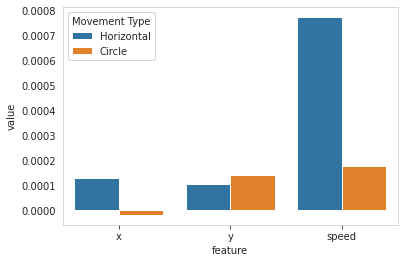

In [130]:
animal_id = 'PV42'
animal_imps = []
for (model_path, _) in [model_paths[animal_id], circle_model_path[animal_id]]:
    tj = TrajClassifier(model_path=f'{TRAJ_DIR}/{model_path}', is_debug=False)
    dataset = tj.get_dataset()
    imp_df = tj.visualize_features_importance(dataset, is_plot=False)
    animal_imps.append(imp_df)

afs = []
for mt_name, af in zip(['Horizontal', 'Circle'], animal_imps):
    v = af.mean()
    v.name = mt_name
    afs.append(v)
afs = pd.DataFrame(afs)
afs = afs.stack().reset_index().rename(columns={'level_0': 'Movement Type', 'level_1': 'feature', 0: 'value'})
sns.barplot(data=afs, x='feature', y='value', hue='Movement Type')

Resampling trajectories to 26 samples from each block_speed class
Resampling trajectories to 26 samples from each block_speed class
Resampling trajectories to 26 samples from each block_speed class
Resampling trajectories to 26 samples from each block_speed class
Resampling trajectories to 26 samples from each block_speed class


<AxesSubplot:xlabel='feature', ylabel='value'>

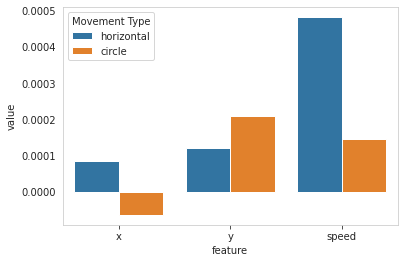

In [134]:
hp_csvs = {
    'horizontal': '/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV42_random_low_horizontal_x_y_speed_2024-09-03T18:33:01.445503.csv',
    'circle': '/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV42_circle_x_y_speed_2024-09-04T21:49:24.286627.csv'
}
animal_imps = []
for mt, hp_csv in hp_csvs.items():
    df = pd.read_csv(hp_csv, index_col=0)
    paths_ = df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False).iloc[:5].model_path.values
    imps_ = []
    for p in paths_:
        tj = TrajClassifier(model_path=p, is_debug=False)
        dataset = tj.get_dataset()
        imp_df = tj.visualize_features_importance(dataset, is_plot=False)
        imps_.append(imp_df.mean())
    v = pd.DataFrame(imps_).mean()
    v.name = mt
    animal_imps.append(v)

animal_imps = pd.DataFrame(animal_imps)
animal_imps = animal_imps.stack().reset_index().rename(columns={'level_0': 'Movement Type', 'level_1': 'feature', 0: 'value'})
sns.barplot(data=animal_imps, x='feature', y='value', hue='Movement Type') 

In [136]:
animal_imps.to_csv('/media/sil2/Data/regev/Papers/internal_models/cache/integrated_gradients_PV42_best_5.csv')

In [ ]:
imps = {}
for animal_id, (model_path, _) in tqdm(model_paths.items()):
    if animal_id in ['PV95', 'PV99']:
        continue
    tj = TrajClassifier(model_path=f'{TRAJ_DIR}/{model_path}', is_debug=False)
    imp_df = tj.check_hidden_states()
    imps[animal_id] = imp_df
sum_imps = reduce(lambda a, b: a.add(b, fill_value=0), list(imps.values()))
sum_imps = (sum_imps / len(imps))
sum_imps = sum_imps.stack().reset_index().rename(columns={'level_0': 'speed', 'level_1': 'feature', 0: 'value'})

In [102]:
sum_imps.groupby('feature').value.mean()

feature
speed    0.000190
x        0.000120
y        0.000163
Name: value, dtype: float64

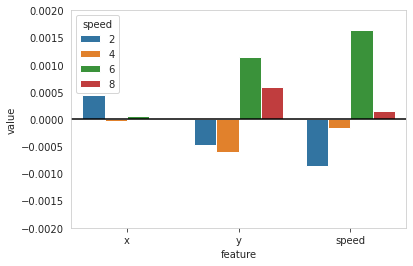

In [99]:
sns.barplot(data=sum_imps, x='feature', y='value', hue='speed')
plt.ylim([-0.002, 0.002])
plt.axhline(0, color='black')

In [ ]:
circle_imps = {}
for animal_id, (model_path, _) in tqdm(circle_model_path.items()):
    if animal_id in ['PV99']:
        continue
    tj = TrajClassifier(model_path=f'{TRAJ_DIR}/{model_path}', is_debug=False)
    imp_df = tj.check_hidden_states()
    circle_imps[animal_id] = imp_df
circle_sum_imps = reduce(lambda a, b: a.add(b, fill_value=0), list(circle_imps.values()))
circle_sum_imps = (circle_sum_imps / len(circle_imps))
circle_sum_imps = circle_sum_imps.stack().reset_index().rename(columns={'level_0': 'speed', 'level_1': 'feature', 0: 'value'})

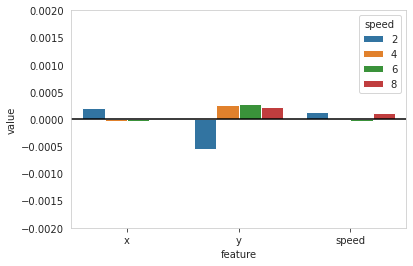

In [100]:
sns.barplot(data=circle_sum_imps, x='feature', y='value', hue='speed')
plt.ylim([-0.002, 0.002])
plt.axhline(0, color='black')

### PV91, random_low_horizontal

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 120), is_resample=False,
                    animal_id='PV91', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.1, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'], is_shuffled_target=True)
tj.train(is_plot=True)

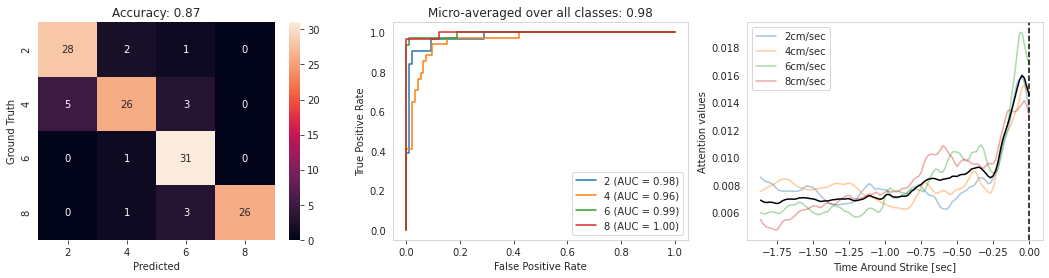

          x         y     speed
4 -0.000090 -0.000009  0.000063
8 -0.000442  0.000567  0.000324
6 -0.000794  0.000952  0.000846
2  0.002680  0.000036 -0.000648


  0%|          | 0/127 [00:00<?, ?it/s]

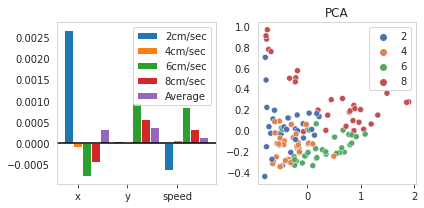

In [41]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240903_112847', is_debug=False)
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Notice! Shuffling randomly the target values


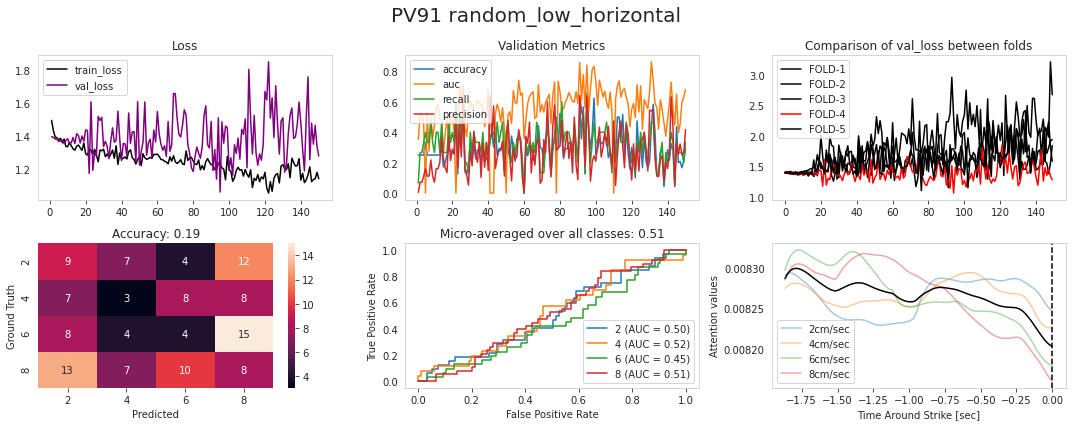

In [3]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV91_random_low_horizontal_x_y_speed_2024-09-03T12:49:46.212140.csv', index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

### PV95, random_low_horizontal

model traj_classifier_PV95_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV95_random_low_horizontal/20240905_145828
Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}


  0%|          | 0/123 [00:00<?, ?it/s]

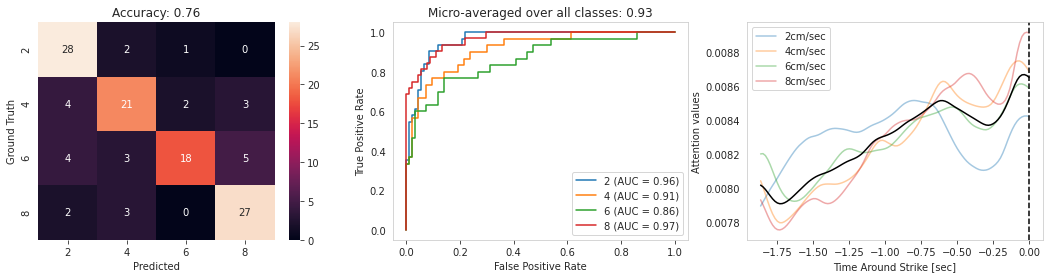

Traj classes count: {2: 31, 4: 30, 6: 30, 8: 32}


  0%|          | 0/123 [00:00<?, ?it/s]

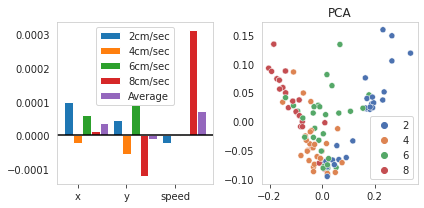

In [34]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV95_random_low_horizontal/20240905_145828')
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values
Traj classes count: {2: 28, 4: 30, 6: 35, 8: 30}
Start train for model traj_classifier_PV95_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV95_random_low_horizontal/20240905_180929
Notice! Shuffling randomly the target values
Traj classes count: {2: 35, 4: 24, 6: 30, 8: 34}


  0%|          | 0/123 [00:00<?, ?it/s]

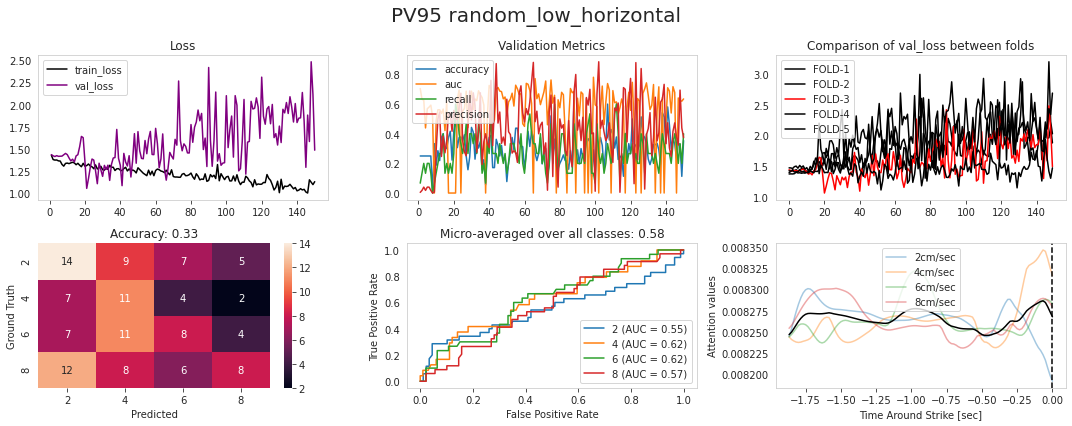

In [16]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 120), is_resample=False,
                    animal_id='PV95', movement_type='random_low_horizontal', is_hit=False, lstm_layers=6, dropout_prob=0.1, lstm_hidden_dim=100,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [ ]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-08-22T15:46:41.191693.csv', index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

### PV163, random_low_horiontal

model traj_classifier_PV163_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240903_125814
Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

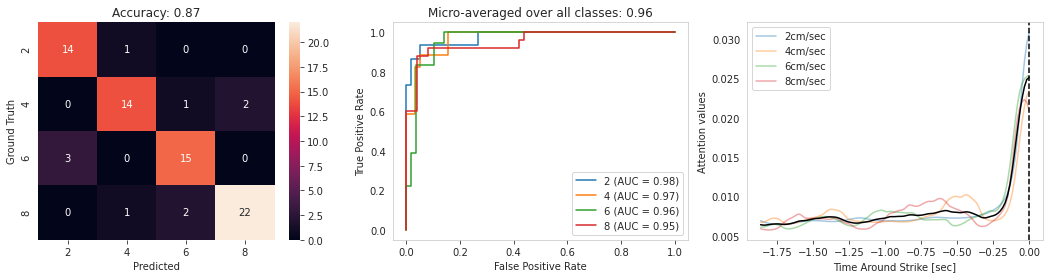

Traj classes count: {2: 15, 4: 17, 6: 18, 8: 25}


  0%|          | 0/75 [00:00<?, ?it/s]

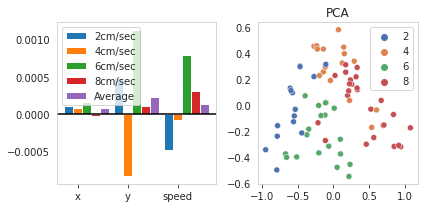

In [35]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240903_125814')
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values
Traj classes count: {2: 16, 4: 20, 6: 20, 8: 19}
Start train for model traj_classifier_PV163_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_random_low_horizontal/20240905_152715
Notice! Shuffling randomly the target values
Traj classes count: {2: 23, 4: 18, 6: 12, 8: 22}


  0%|          | 0/75 [00:00<?, ?it/s]

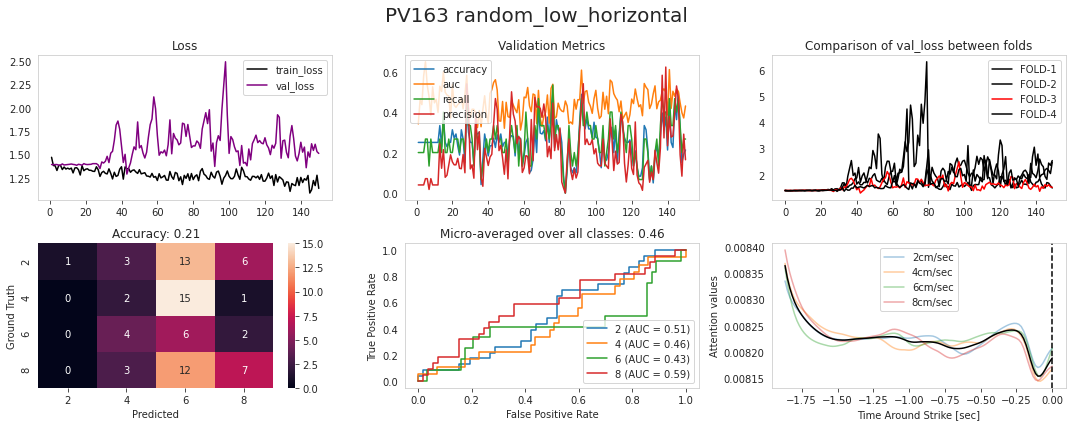

In [5]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV163_random_low_horizontal_x_y_speed_2024-09-03T13:36:57.731228.csv',
                 index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

### PV99, random_low_horiontal

model traj_classifier_PV99_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV99_random_low_horizontal/20240903_135446
Traj classes count: {2: 30, 4: 28, 6: 33, 8: 33}


  0%|          | 0/124 [00:00<?, ?it/s]

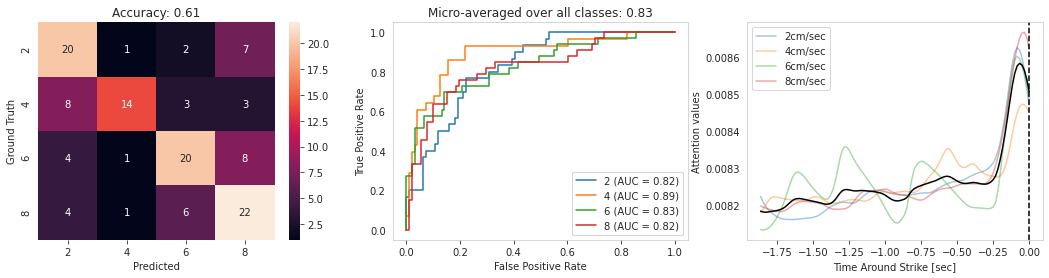

Traj classes count: {2: 30, 4: 28, 6: 33, 8: 33}


  0%|          | 0/124 [00:00<?, ?it/s]

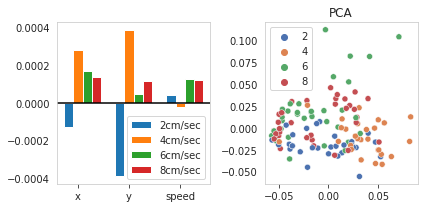

In [6]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV99_random_low_horizontal/20240903_135446')
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values
Traj classes count: {2: 34, 4: 34, 6: 30, 8: 26}
Start train for model traj_classifier_PV99_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#5
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV99_random_low_horizontal/20240905_153634
Notice! Shuffling randomly the target values
Traj classes count: {2: 24, 4: 26, 6: 36, 8: 38}


  0%|          | 0/124 [00:00<?, ?it/s]

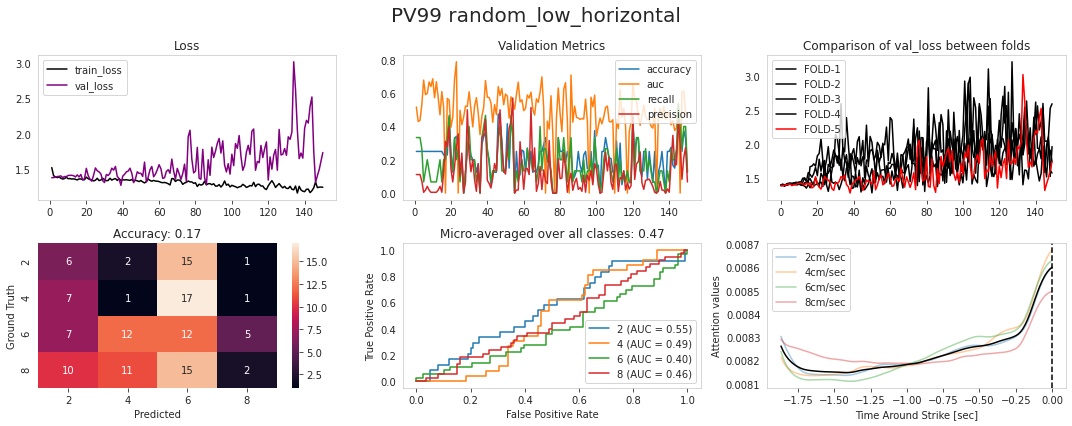

In [7]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV99_random_low_horizontal_x_y_speed_2024-09-03T15:15:46.951081.csv',
                 index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

### PV42, random_low_horiontal

model traj_classifier_PV42_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV42_random_low_horizontal/20240903_170358
Traj classes count: {2: 30, 4: 29, 6: 31, 8: 31}


  0%|          | 0/121 [00:00<?, ?it/s]

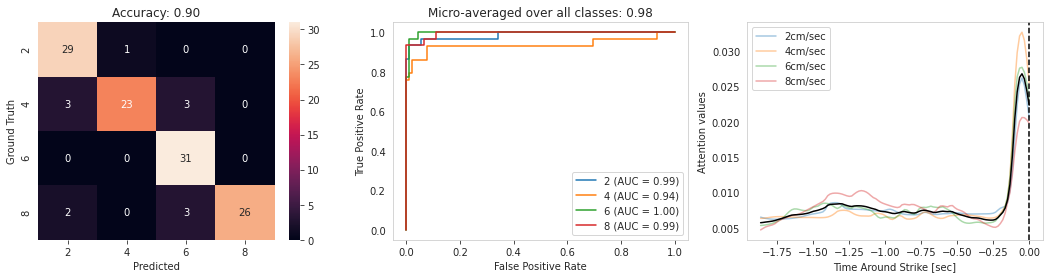

Traj classes count: {2: 30, 4: 29, 6: 31, 8: 31}


  0%|          | 0/121 [00:00<?, ?it/s]

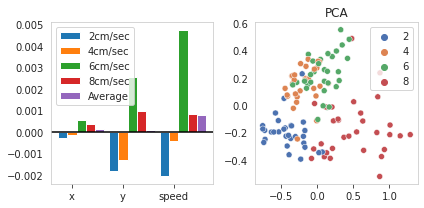

In [38]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV42_random_low_horizontal/20240903_170358')
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values
Traj classes count: {2: 23, 4: 26, 6: 34, 8: 38}
Start train for model traj_classifier_PV42_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV42_random_low_horizontal/20240905_154550
Notice! Shuffling randomly the target values
Traj classes count: {2: 35, 4: 21, 6: 30, 8: 35}


  0%|          | 0/121 [00:00<?, ?it/s]

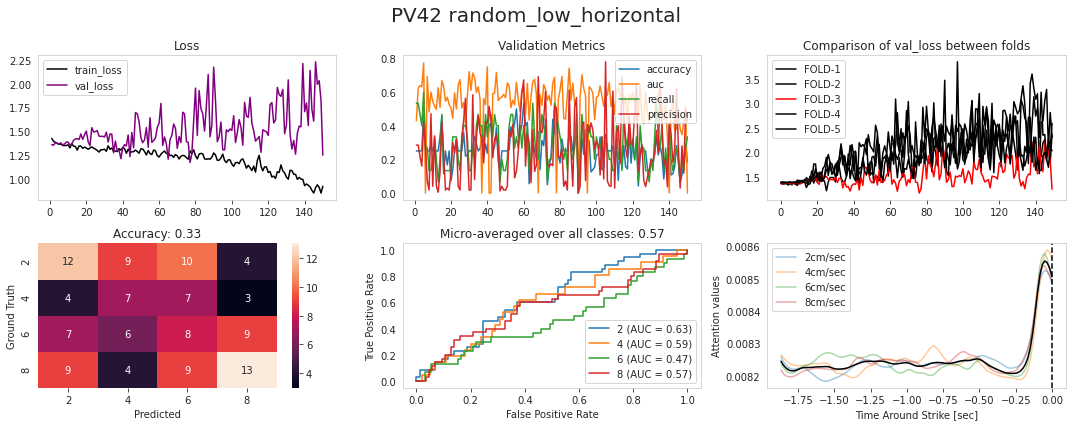

In [9]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 120), is_resample=False,
                    animal_id='PV42', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.1, lstm_hidden_dim=100,
                    feature_names=['x', 'y', 'speed'], is_shuffled_target=True)
tj.train(is_plot=True)

In [ ]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV42_random_low_horizontal_x_y_speed_2024-09-03T18:33:01.445503.csv',
                 index_col=0)
df.query('metric=="auc"').sort_values(by='value', ascending=False)

### PV80, random_low_horiontal

model traj_classifier_PV80_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV80_random_low_horizontal/20240903_152757
Traj classes count: {2: 31, 4: 32, 6: 30, 8: 33}


  0%|          | 0/126 [00:00<?, ?it/s]

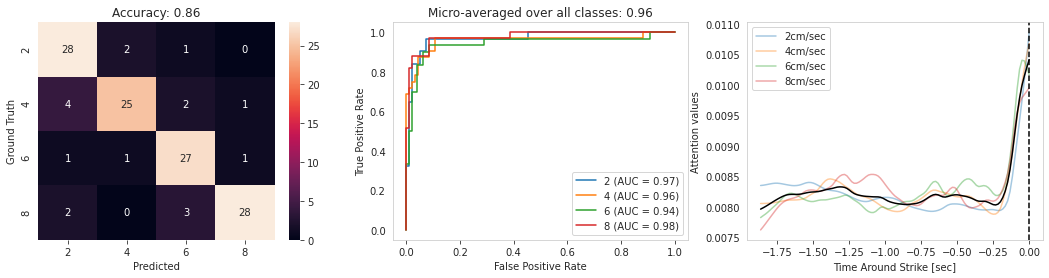

Traj classes count: {2: 31, 4: 32, 6: 30, 8: 33}


  0%|          | 0/126 [00:00<?, ?it/s]

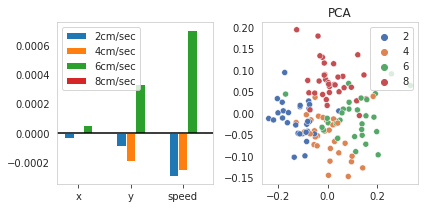

In [10]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV80_random_low_horizontal/20240903_152757')
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values
Traj classes count: {2: 32, 4: 29, 6: 34, 8: 31}
Start train for model traj_classifier_PV80_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV80_random_low_horizontal/20240905_155821
Notice! Shuffling randomly the target values
Traj classes count: {2: 38, 4: 34, 6: 23, 8: 31}


  0%|          | 0/126 [00:00<?, ?it/s]

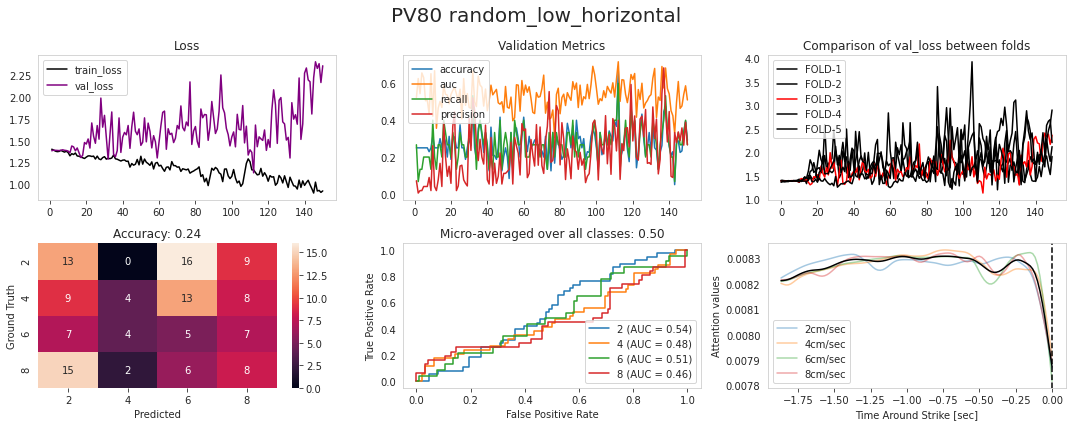

In [11]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 120), is_resample=False,
                    animal_id='PV80', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=150,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [ ]:
res_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV80_2024-08-25T18:34:31.182327.csv', index_col=0)
res_df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)
movement_type = 'random_low_horizontal'

### PV85, random_low_horiontal

model traj_classifier_PV85_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV85_random_low_horizontal/20240905_192044
Traj classes count: {2: 29, 4: 30, 6: 31, 8: 32}


  0%|          | 0/122 [00:00<?, ?it/s]

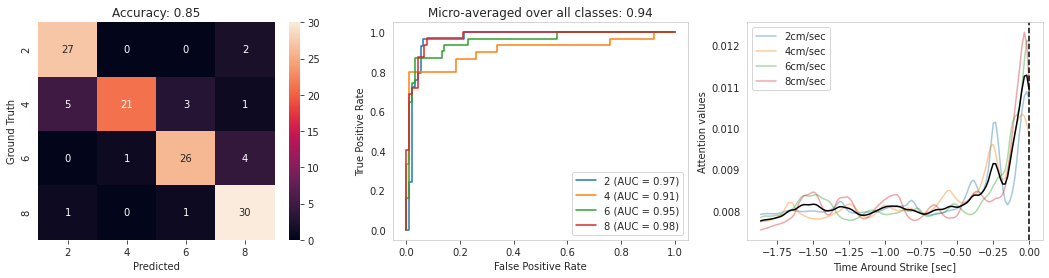

Traj classes count: {2: 29, 4: 30, 6: 31, 8: 32}


  0%|          | 0/122 [00:00<?, ?it/s]

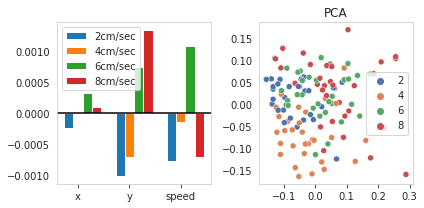

In [19]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV85_random_low_horizontal/20240905_192044')
tj.all_data_evaluation()
tj.check_hidden_states();

Notice! Shuffling randomly the target values
Traj classes count: {2: 32, 4: 36, 6: 25, 8: 29}
Start train for model traj_classifier_PV85_random_low_horizontal. Train will be running on cuda:0 device


  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

Chosen model is of Fold#3
model saved to /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV85_random_low_horizontal/20240908_121815
Notice! Shuffling randomly the target values
Traj classes count: {2: 27, 4: 32, 6: 37, 8: 26}


  0%|          | 0/122 [00:00<?, ?it/s]

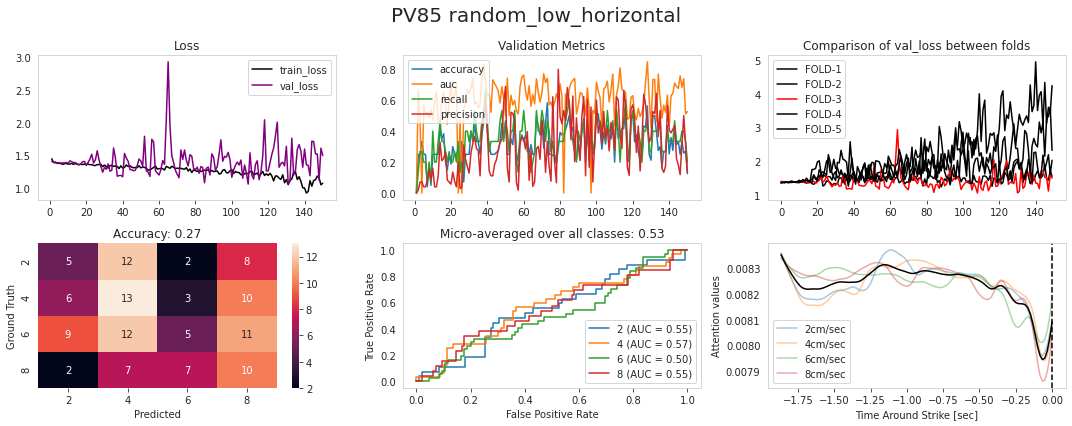

In [20]:
tj.is_shuffled_target = True
tj.dataset = tj.get_dataset()
tj.train(is_plot=True);

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='PV85', movement_type='random_low_horizontal', is_hit=False, lstm_layers=6, dropout_prob=0.4, lstm_hidden_dim=50,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [17]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV85_random_low_horizontal_x_y_speed_2024-09-05T20:49:42.115790.csv',
                 index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

,metric,value,animal_id,movement_type,dropout_prob,lstm_hidden_dim,lstm_layers,model_path
244,overall_accuracy,0.901639,PV85,random_low_horizontal,0.6,150,6,/media/sil2/Data/regev/datasets/trajs/traj_cla...
48,overall_accuracy,0.877049,PV85,random_low_horizontal,0.1,150,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...
27,overall_accuracy,0.852459,PV85,random_low_horizontal,0.1,100,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...
6,overall_accuracy,0.795082,PV85,random_low_horizontal,0.1,50,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...
111,overall_accuracy,0.795082,PV85,random_low_horizontal,0.3,150,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...
90,overall_accuracy,0.778689,PV85,random_low_horizontal,0.3,100,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...
34,overall_accuracy,0.770492,PV85,random_low_horizontal,0.1,100,6,/media/sil2/Data/regev/datasets/trajs/traj_cla...
216,overall_accuracy,0.754098,PV85,random_low_horizontal,0.6,100,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...
139,overall_accuracy,0.737705,PV85,random_low_horizontal,0.4,50,6,/media/sil2/Data/regev/datasets/trajs/traj_cla...
153,overall_accuracy,0.729508,PV85,random_low_horizontal,0.4,100,4,/media/sil2/Data/regev/datasets/trajs/traj_cla...


### PV91, circle

model traj_classifier_PV91_circle load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_circle/20240904_193403
Resampling trajectories to 28 samples from each block_speed class
Traj classes count: {2: 28, 4: 28, 6: 28, 8: 28}


  0%|          | 0/112 [00:00<?, ?it/s]

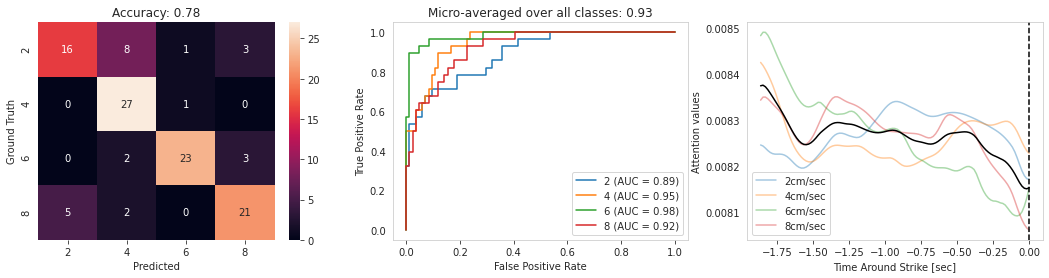

Resampling trajectories to 28 samples from each block_speed class
Traj classes count: {2: 28, 4: 28, 6: 28, 8: 28}
x        0.000025
y       -0.000001
speed    0.000018
dtype: float64


  0%|          | 0/112 [00:00<?, ?it/s]

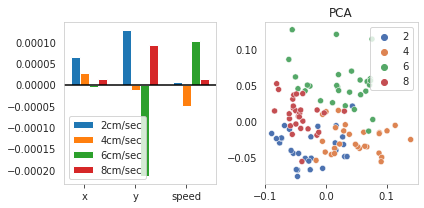

In [27]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_circle/20240904_193403')
tj.all_data_evaluation()
tj.check_hidden_states();

Resampling trajectories to 28 samples from each block_speed class
Traj classes count: {2: 28, 4: 28, 6: 28, 8: 28}


  0%|          | 0/112 [00:00<?, ?it/s]

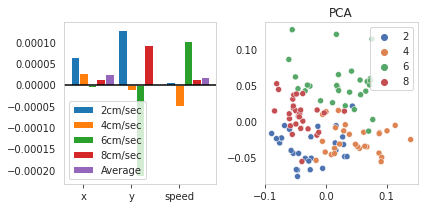

In [32]:
tj.check_hidden_states();

### PV163, circle

model traj_classifier_PV163_circle load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_circle/20240904_071718
Traj classes count: {2: 22, 4: 23, 6: 35, 8: 31}


  0%|          | 0/111 [00:00<?, ?it/s]

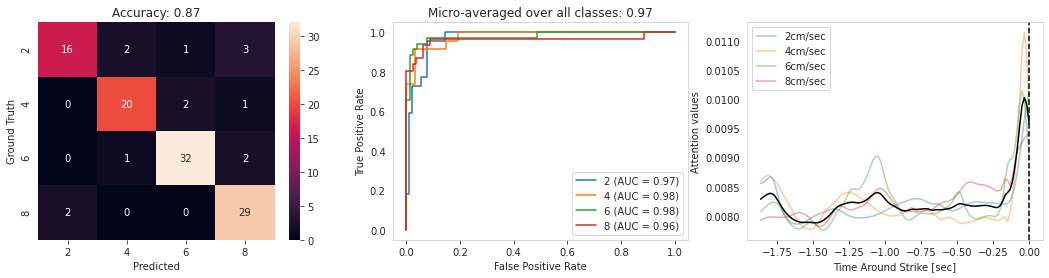

Traj classes count: {2: 22, 4: 23, 6: 35, 8: 31}


  0%|          | 0/111 [00:00<?, ?it/s]

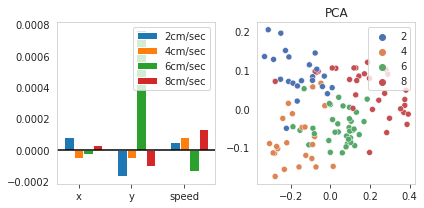

In [22]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV163_circle/20240904_071718')
tj.all_data_evaluation()
tj.check_hidden_states();

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='PV163', movement_type='circle', is_hit=False, lstm_layers=6, dropout_prob=0.1, lstm_hidden_dim=100,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

In [ ]:
df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_PV163_circle_2024-08-26T20:01:40.004192.csv', index_col=0)
df.query('metric=="overall_accuracy"').sort_values(by='value', ascending=False)

### PV99, circle

model traj_classifier_PV99_circle load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV99_circle/20240904_080452
Traj classes count: {2: 15, 4: 22, 6: 27, 8: 14}


  0%|          | 0/78 [00:00<?, ?it/s]

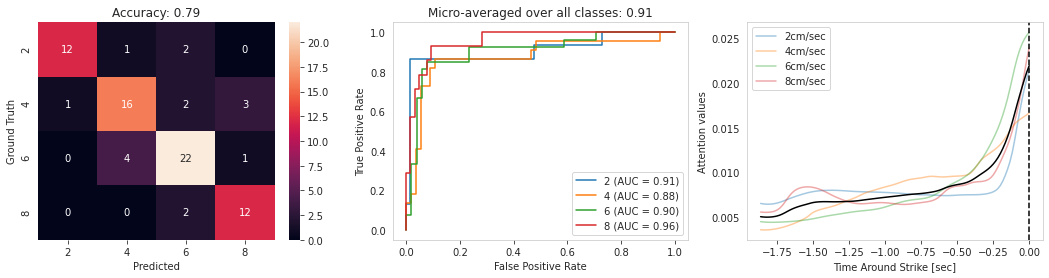

Traj classes count: {2: 15, 4: 22, 6: 27, 8: 14}


  0%|          | 0/78 [00:00<?, ?it/s]

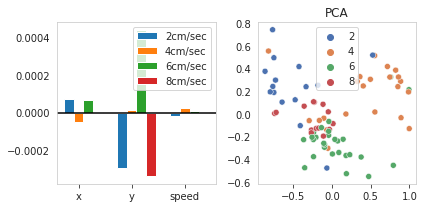

In [23]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV99_circle/20240904_080452')
tj.all_data_evaluation()
tj.check_hidden_states();

### PV80, circle

model traj_classifier_PV80_circle load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV80_circle/20240904_101710
Traj classes count: {2: 27, 4: 9, 6: 26, 8: 21}


  0%|          | 0/83 [00:00<?, ?it/s]

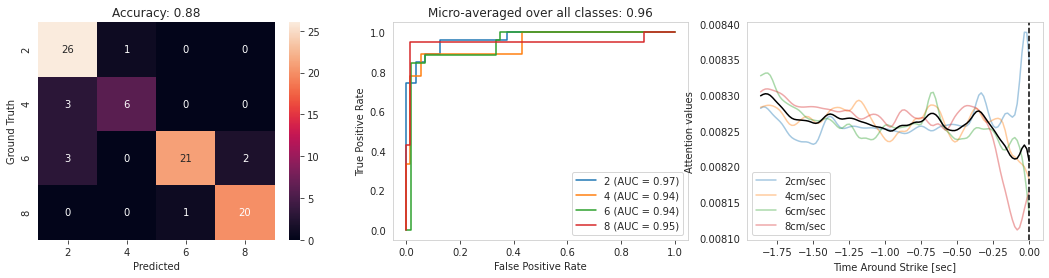

Traj classes count: {2: 27, 4: 9, 6: 26, 8: 21}


  0%|          | 0/83 [00:00<?, ?it/s]

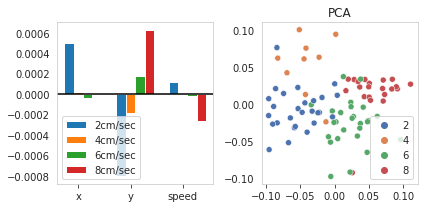

In [24]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV80_circle/20240904_101710')
tj.all_data_evaluation()
tj.check_hidden_states();

### PV42, circle

model traj_classifier_PV42_circle load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_PV42_circle/20240904_203232
Resampling trajectories to 26 samples from each block_speed class
Traj classes count: {2: 26, 4: 26, 6: 26, 8: 26}


  0%|          | 0/104 [00:00<?, ?it/s]

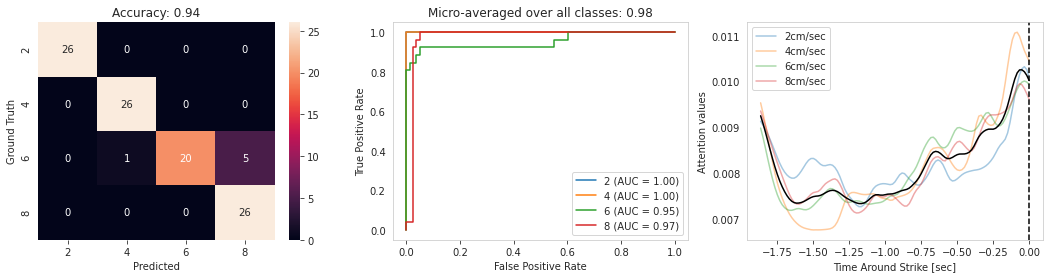

Resampling trajectories to 26 samples from each block_speed class
Traj classes count: {2: 26, 4: 26, 6: 26, 8: 26}


  0%|          | 0/104 [00:00<?, ?it/s]

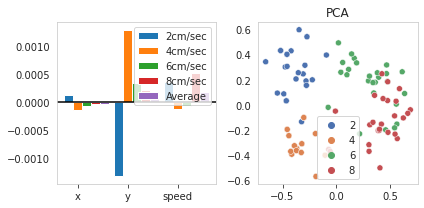

In [39]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV42_circle/20240904_203232')
tj.all_data_evaluation()
tj.check_hidden_states();

### Visualize Model

In [ ]:
from torchview import draw_graph

model_graph = draw_graph(tj.model, input_size=(1, 181, 3), device='meta', save_graph=True, filename='traj_model_visualization', 
                         directory='/media/sil2/Data/regev/Papers/internal_models/figures')
model_graph.visual_graph

In [ ]:
vars(model_graph)

In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter

model = tj.model.to(torch.device('cpu'))
dummy_input = tj.dataset[0][0].to(torch.device('cpu'))

writer = SummaryWriter("../output/models/trajs")
writer.add_graph(model, dummy_input)
writer.close()

### All animals, Circle

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=True,
                    feature_names=['x', 'y', 'speed_x', 'speed_y'],
                    animal_id='all', movement_type='circle', is_hit=False, lstm_layers=6, dropout_prob=0.5)
tj.train(is_plot=True)
tj.check_hidden_states()

model traj_classifier_all_circle load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_circle/20240904_164448
Resampling trajectories to 65 samples from each block_speed class
Traj classes count: {2: 65, 4: 65, 6: 65, 8: 65}


  0%|          | 0/260 [00:00<?, ?it/s]

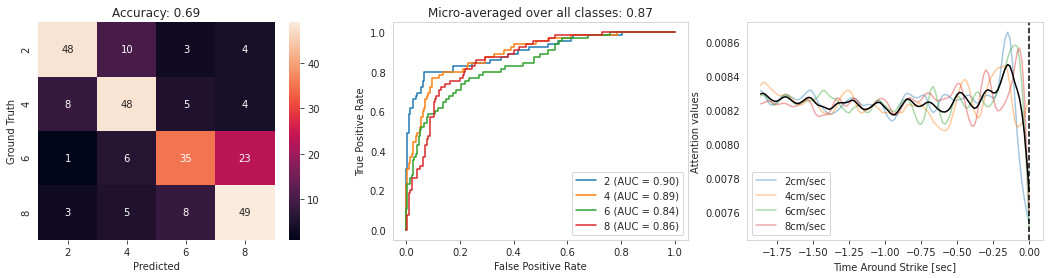

Resampling trajectories to 65 samples from each block_speed class
Traj classes count: {2: 65, 4: 65, 6: 65, 8: 65}


  0%|          | 0/260 [00:00<?, ?it/s]

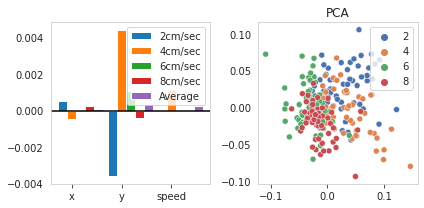

In [37]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_circle/20240904_164448')
tj.all_data_evaluation()
tj.check_hidden_states();

### All animals, random_low_horizontal

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 180), is_resample=False,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=6, dropout_prob=0.4, lstm_hidden_dim=50,
                    feature_names=['x', 'y', 'speed'])
tj.train(is_plot=True)
tj.check_hidden_states();

model traj_classifier_all_random_low_horizontal load from: /media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240903_221728
Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}


  0%|          | 0/449 [00:00<?, ?it/s]

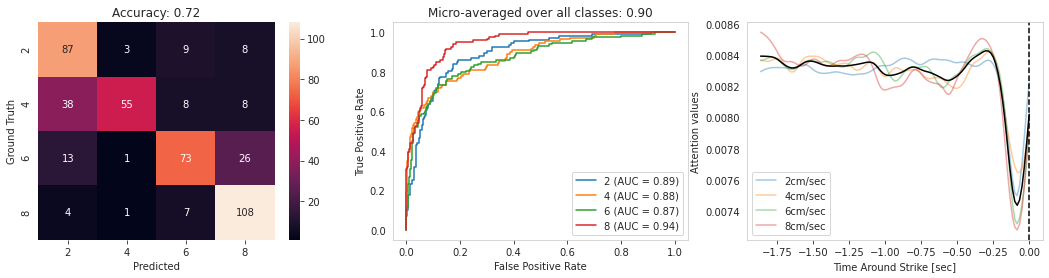

Traj classes count: {2: 107, 4: 109, 6: 113, 8: 120}


  0%|          | 0/449 [00:00<?, ?it/s]

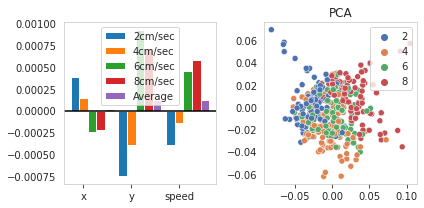

In [36]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240903_221728')
tj.all_data_evaluation()
tj.check_hidden_states();

In [ ]:
attns = {}
for model_path in tqdm(model_paths):
    tj = TrajClassifier(model_path=model_path)
    tj.model.eval()
    dataset = tj.get_dataset()
    y_true, y_pred, y_score = [], [], []
    attns = {}
    for x, y in dataset:
        outputs, attention_weights = tj.model(x.to(tj.device).unsqueeze(0), is_attn=True)
        attns.setdefault(tj.targets[y.item()], []).append(attention_weights.detach().cpu().numpy())
        label, prob = tj.predict_proba(outputs, is_all_probs=True)
        y_true.append(y.item())
        y_pred.append(label.item())
        y_score.append(prob.detach().cpu().numpy())

    for bug_speed in tj.targets:
        att = attns[bug_speed]
        att = np.vstack(att).mean(axis=0)
        att[:5] = np.nan
        attns.setdefault(bug_speed, []).append(att)
        
for bug_speed, a in attns.items():
    a_ = np.vstack(a).mean(axis=0)
    plt.plot(a_, label=str(bug_speed))
plt.legend()

In [ ]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_PV91_random_low_horizontal/20240821_133922')
# tj.all_data_evaluation()
tj.check_hidden_states()

In [ ]:
import torch
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

dataset = tj.get_dataset()
torch.backends.cudnn.enabled=False
tj.model.eval()
ig = IntegratedGradients(tj.model)

fig, axes = plt.subplots(1+len(tj.feature_names), len(tj.targets), figsize=(18, 3*(1+len(tj.feature_names))))

res = {}
aggregated_attributions, all_data = {}, {}
for x, y in dataset:
    input_ = x.to(tj.device).unsqueeze(0)
    baseline = torch.zeros(input_.shape).to(tj.device)
    attr, delta = ig.attribute(input_, baseline, target=y.item(), return_convergence_delta=True)
    aggregated_attributions.setdefault(tj.targets[y.item()], []).append(attr)
    all_data.setdefault(tj.targets[y.item()], []).append(input_.cpu().numpy().squeeze())

all_data_limits = {k: [0, 0] for k in tj.feature_names}
for target, x in aggregated_attributions.items():
    x = torch.cat(x, dim=0)
    importance = np.mean(x.cpu().detach().numpy(), axis=0)
    imp = pd.Series(importance[-1])
    idx = imp.abs().sort_values().index.tolist()
    imp = imp.reindex(idx)
    imp.index = [tj.feature_names[i] for i in imp.index]
    max_x = np.abs(importance[-1]).max()
    res[target] = (imp, max_x)
    
    all_data[target] = np.vstack(all_data[target])
    for k, fn in enumerate(tj.feature_names):
        if all_data_limits[fn][1] < max(all_data[target][:, k]):
            all_data_limits[fn][1] = max(all_data[target][:, k])
        if all_data_limits[fn][0] > min(all_data[target][:, k]):
            all_data_limits[fn][0] = min(all_data[target][:, k])

max_x = max([x[1] for x in res.values()])
for i, target in enumerate(sorted(list(res.keys()))):
    imp, _ = res[target]
    imp.plot.barh(ax=axes[0, i])
    axes[0, i].set_xlim([-max_x, max_x])
    axes[0, i].set_ylabel('Features')
    axes[0, i].set_title(f'{target}cm/sec')
    axes[0, i].axvline(0, color='black')
    
    for j, feature_name in enumerate(tj.feature_names):
        bins = np.arange(*all_data_limits[feature_name], 0.5)
        axes[j+1, i].hist(all_data[target][:, j], bins=bins)
        if i == 0:
            axes[j+1, i].set_ylabel(feature_name)

In [ ]:
imp.values

In [ ]:
y.item()

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False, is_shuffled_target=True,
                    animal_id='PV91', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
tj.train(is_plot=True);

### Target = is_hit

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,
                    target_name='is_hit', targets=[0, 1])
tj.train(is_plot=True);

### Target = bug type

In [ ]:
tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=True,
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50,
                    target_name='bug_type', targets=['worm', 'cockroach', 'red_beetle', 'green_beetle'])
tj.train(is_plot=True);

### Feature Importance

In [ ]:
# tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(-2, 150), is_resample=False,
#                     feature_names=['x', 'y', 'prob', 'speed', 'angle'], 
#                     animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
# tj.train(is_plot=True)

tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240722_105828')
tj.check_hidden_states()

### Find optimal span

In [ ]:
res_df = []

for t_start in np.arange(-3, 2, 0.5):
    for span_sec in [60, 90, 120, 150, 180, 210]:
        if (t_start + (span_sec / 60)) > 3:
            continue
        print(f'Start training with t_start: {t_start}, span_sec: {span_sec}')
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(t_start, span_sec), is_resample=False,
                    feature_names=['x', 'y', 'speed_x', 'speed_y'],
                    animal_id='all', movement_type='random_low_horizontal', is_hit=False, lstm_layers=4, dropout_prob=0.3, lstm_hidden_dim=50)
            tj.train(is_plot=False)
            best_i = np.argmin([x['score'] for x in tj.history])
            best_epoch = np.argmin(tj.history[best_i]['metrics']['val_loss'])
            for metric, l in tj.history[best_i]['metrics'].items():
                res_df.append({'t_start': t_start, 'span_sec': span_sec, 'metric': metric, 'value': l[best_epoch]})
        except Exception as exc:
            print(f'Error in t_start: {t_start}, span_sec: {span_sec}; {exc}')

res_df = pd.DataFrame(res_df)
filename = f'{TRAJ_DIR}/optimal_span_{datetime.now().isoformat()}.csv'
res_df.to_csv(filename)

In [ ]:
trajs[103]

In [ ]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
    d_ = pickle.load(f)
    strk_df, trajs = d_['strk_df'], d_['trajs']

In [ ]:
strk_df.animal_id.value_counts()

In [ ]:
res = {}
for strike_id, row in strk_df.query('movement_type=="circle"').iterrows():
    res.setdefault(row.block_speed, []).extend(trajs[strike_id].prob.values.tolist())

res = dict(sorted(res.items(), key=lambda kv: kv[0]))
fig, axes = plt.subplots(1, len(res), figsize=(20, 4))
for i, (block_speed, l) in enumerate(res.items()):
    axes[i].hist(l, bins=np.arange(0, 1, 0.01))
    axes[i].set_title(str(block_speed))
    axes[i].set_ylim([0, 160])

### plot trajectory examples

In [ ]:
def plot_trajs_examples(animal_id, movement_type, n_samples=18):
    cols = 6
    rows = int(np.ceil(n_samples/cols))
    with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
        d_ = pickle.load(f)
        strk_df, trajs = d_['strk_df'], d_['trajs']
    g = strk_df.query(f'animal_id=="{animal_id}" and movement_type=="{movement_type}"').groupby('block_speed').apply(
        lambda x: x.sample(n_samples, random_state=0, replace=False))
    block_speeds = g.index.get_level_values(0).unique().tolist() 

    fig = plt.figure(figsize=(25, len(block_speeds)*rows*3), constrained_layout=True)
    subfigs = fig.subfigures(len(block_speeds), 1, hspace=0.1)

    for k, block_speed in enumerate(block_speeds):
        axes = subfigs[k].subplots(rows, cols)  
        axes = axes.flatten()
        for i, strike_id in enumerate(g.loc[block_speed].index):
            t = trajs[strike_id]
            total_dist = np.sqrt((t.x.diff() ** 2) + (t.y.diff() ** 2)).sum()
            axes[i].plot(t.x, t.y)
            axes[i].set_title(f'Strike {strike_id} (hit:{g.loc[block_speed].loc[strike_id].is_hit},dist={total_dist:.1f})')
            axes[i].set_xlim([0, 55])
            axes[i].set_ylim([-4, 50])
        subfigs[k].suptitle(f'Block Speed: {block_speed}')
    fig.savefig(f'{TRAJ_DIR}/trajs_examples_{animal_id}_{movement_type}.pdf', bbox_inches='tight')


plot_trajs_examples('PV163', 'random_low_horizontal', n_samples=12)

In [ ]:
tj = TrajClassifier(model_path='/media/sil2/Data/regev/datasets/trajs/traj_classifier_all_random_low_horizontal/20240714_123934')
tj.all_data_evaluation()

In [ ]:
res = []
for sub_sect in [(-3, 180), (-2.5, 150), (-2, 120), (-1.5, 90), (-1, 60), (-0.5, 30), (-0.2, 12), (-0.1, 6)]:
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=sub_sect, is_resample=False,
                            animal_id='PV91', movement_type='random_low_horizontal', is_single_strike=False)
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['sub_section'] = sub_sect
        res.append(d)
    except Exception as exc:
        print(f'{sub_sect}: {exc}')

res = pd.DataFrame(res).set_index('sub_section')
res.plot()

In [ ]:
np.arange(-3, 2.5, 0.5)

In [ ]:
movement_type = 'random_low_horizontal'
for animal_id in ['PV91', 'PV163']:
    res = []
    for start_time in np.arange(-3, 2.5, 0.25):
        try:
            tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(start_time, 60), is_resample=False,
                                animal_id=animal_id, movement_type=movement_type, is_hit=False)
            tj.train(is_plot=False)
            d = tj.calc_auc()
            d['start_time'] = start_time + 0.5
            res.append(d)
        except Exception as exc:
            print(f'{exc}')

    res = pd.DataFrame(res).set_index('start_time')
    plt.figure()
    res.plot()
    plt.title(f'Animal ID: {animal_id}, Movement Type: {movement_type}')
    plt.ylabel('AUC')

In [ ]:
res.mean(axis=1).idxmax()

In [ ]:
res = {}
for strike_id, row in strk_df.iterrows():
    res.setdefault(row.animal_id, 0)
    if len(trajs[strike_id].frame_strike_id.value_counts()) == 1:
        res[row.animal_id] += 1

for animal_id, c in res.items():
    total = len(strk_df.query(f'animal_id=="{animal_id}"'))
    print(f'{animal_id}: {c}/{total}')

In [ ]:
with open('/media/sil2/Data/regev/datasets/trajs/trajs_2s_after.pkl', 'rb') as f:
    d_ = pickle.load(f)
    strk_df, trajs = d_['strk_df'], d_['trajs']

In [ ]:
strk_df.bug_type.value_counts()

In [ ]:
pd.DataFrame(res).set_index('t0').plot()

In [ ]:
trajs[103]

In [ ]:
row = strk_df.iloc[0]
row.time

In [ ]:
res2 = []
for t0 in (np.arange(-5, 60, 10) / 60):
    try:
        tj = TrajClassifier(save_model_dir=TRAJ_DIR, is_shuffle_dataset=False, sub_section=(t0, 60),
                        animal_id='PV91', movement_type='random_low_horizontal')
        tj.train(is_plot=False)
        d = tj.calc_auc()
        d['t0'] = t0
        res2.append(d)
    except Exception as exc:
        print(f'Error in t0: {t0}; {exc}')
        continue
    
res2 = pd.DataFrame(res2)
res2

In [ ]:
pd.concat([pd.DataFrame(res), res2]).set_index('t0').sort_index().plot()

In [ ]:
eval_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-07-16T21:30:01.178974.csv', index_col=0)
# eval_df = pd.read_csv('/media/sil2/Data/regev/datasets/trajs/hyperparameters_results_2024-07-15T19:54:59.448642.csv', index_col=0)

In [ ]:
eval_df.query('metric=="val_loss"').sort_values(by='value')

In [ ]:
eval_df.query('metric=="accuracy"').sort_values(by='value', ascending=False)